# Class Activation Mapping

In [1]:
import torch
from torchvision import models, datasets, transforms
from torch import nn, optim
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.nn import functional as F
import glob
import numpy as np
import PIL
import cv2
from matplotlib import pyplot as plt
%matplotlib inline

## Use a pre-trained VGG-19

In [2]:
model = models.vgg19(pretrained=True)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Modify the network to enable CAM output

In [3]:
# Freeze layers
for param in model.parameters():
    param.requires_grad = False
    
# Modify the last two convolutions
model.features[32] = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
model.features[34] = nn.Conv2d(512, 10, kernel_size=3, stride=1, padding=1)

# Global Average Pooling
model.avgpool = nn.AdaptiveAvgPool2d(1)
    
# Classifier
model.classifier = nn.Linear(10, 10)

In [4]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Fine-tuning with STL10

In [5]:
class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
            yield (self.func(*b))

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = datasets.STL10('data', split='train', transform=train_transforms, download=True)
valid_dataset = datasets.STL10('data', split='test', transform=valid_transforms, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=True, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [7]:
train_dataset.classes

['airplane',
 'bird',
 'car',
 'cat',
 'deer',
 'dog',
 'horse',
 'monkey',
 'ship',
 'truck']

## Training

In [8]:
torch.manual_seed(1)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def to_device(x, y):
    return x.to(device), y.to(device, dtype=torch.int64)

train_loader = WrappedDataLoader(train_loader, to_device)
valid_loader = WrappedDataLoader(valid_loader, to_device)

In [10]:
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=.0001)
n_epochs = 20

In [11]:
def loss_batch(model, loss_func, x, y, opt=None):
    loss = loss_func(model(x), y)
    
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()

    return loss.item(), len(x)

In [12]:
def valid_batch(model, loss_func, x, y):
    output = model(x)
    loss = loss_func(output, y)
    pred = torch.argmax(output, dim=1)
    correct = pred == y.view(*pred.shape)
    
    return loss.item(), torch.sum(correct).item(), len(x)

In [13]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):
    for epoch in range(epochs):
        # Train model
        model.train()
        losses, nums = zip(*[loss_batch(model, loss_func, x, y, opt) for x, y in train_dl])
        train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        # Validation model
        model.eval()
        with torch.no_grad():
            losses, corrects, nums = zip(*[valid_batch(model, loss_func, x, y) for x, y in valid_dl])
            valid_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
            valid_accuracy = np.sum(corrects) / np.sum(nums) * 100
            print(f"[Epoch {epoch+1}/{epochs}] "
                  f"Train loss: {train_loss:.6f}\t"
                  f"Validation loss: {valid_loss:.6f}\t",
                  f"Validation accruacy: {valid_accuracy:.3f}%")

In [14]:
fit(n_epochs, model, criterion, optimizer, train_loader, valid_loader)

[Epoch 1/20] Train loss: 1.943150	Validation loss: 1.527864	 Validation accruacy: 47.387%
[Epoch 2/20] Train loss: 1.629961	Validation loss: 1.246078	 Validation accruacy: 52.612%
[Epoch 3/20] Train loss: 1.480907	Validation loss: 1.084732	 Validation accruacy: 61.387%
[Epoch 4/20] Train loss: 1.351676	Validation loss: 0.948232	 Validation accruacy: 65.800%
[Epoch 5/20] Train loss: 1.236577	Validation loss: 0.805159	 Validation accruacy: 67.975%
[Epoch 6/20] Train loss: 1.150995	Validation loss: 0.685268	 Validation accruacy: 77.012%
[Epoch 7/20] Train loss: 1.060874	Validation loss: 0.577954	 Validation accruacy: 81.963%
[Epoch 8/20] Train loss: 0.975091	Validation loss: 0.500621	 Validation accruacy: 84.750%
[Epoch 9/20] Train loss: 0.888998	Validation loss: 0.445844	 Validation accruacy: 86.112%
[Epoch 10/20] Train loss: 0.824812	Validation loss: 0.429994	 Validation accruacy: 86.250%
[Epoch 11/20] Train loss: 0.810733	Validation loss: 0.384862	 Validation accruacy: 87.150%
[Epoch 1

## Model save

In [15]:
torch.save(model, 'vgg19-cam.pt')

## Model load

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = torch.load('vgg19-cam.pt', map_location=device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (17): ReLU(inplace)

## Generate class activation mapping

In [17]:
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bz, nc, h, w = feature_conv.shape
    cam = weight_softmax[class_idx].dot(feature_conv.reshape((nc, h*w)))
    cam = cam.reshape(h, w)
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
    cam_img = np.uint8(255 * cam_img)
    output_cam = cv2.resize(cam_img, size_upsample)
    return output_cam

In [18]:
def predict(model, x):
    # hook the feature extractor
    features = []
    def hook_feature(module, input, output):
        features.append(output.data.cpu().numpy())
    
    # register forward hook
    hook = model._modules.get('features').register_forward_hook(hook_feature)

    # get the softmax weight
    params = list(model.parameters())
    weight_softmax = np.squeeze(params[-2].data.cpu().numpy())
    
    logit = model(x)
    h_x = F.softmax(logit, dim=1).data.squeeze()
    probs, idx = h_x.sort(0, True)
    probs = probs.cpu().numpy()
    idx = idx.cpu().numpy()
    
    # unregister hook
    hook.remove()
    
    return features[0], weight_softmax, idx[0]

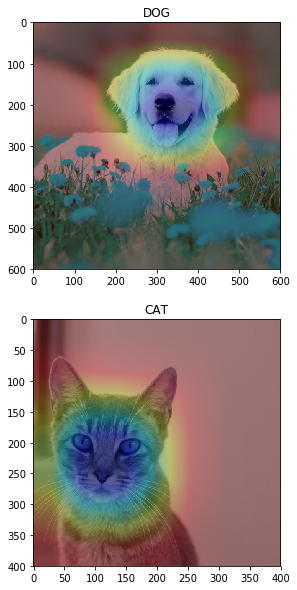

In [19]:
preprocess = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

classes = ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']

plt.figure(figsize=(10, 10))
for i,file in enumerate(glob.glob('./test_images/*')):
    image = PIL.Image.open(file)
    tensor = preprocess(image).unsqueeze(0).to(device)
    features, weight, label = predict(model, tensor)
    # generate class activation mapping for the top1 prediction
    CAM = returnCAM(features, weight, label)
    img = cv2.imread(file)
    height, width, _ = img.shape
    heatmap = cv2.applyColorMap(cv2.resize(CAM,(width, height)), cv2.COLORMAP_JET)
    result = heatmap * 0.3 + img * 0.5
    plt.subplot(2, 1, i+1)
    plt.title(classes[label].upper())
    plt.imshow(result.astype(np.int))